# Weekly LAI: exploratory analysis

In [2]:
import os
import time
import datetime
import random as rd
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
%matplotlib inline

Change the filepath to the path containing the netcdf file:

In [5]:
filepath = '/home/stijndc/Desktop/datafiles/SAT_EX/netcdf files/' 

Read in the file, apply the scaling factor and extract the LAI, latitude, longitude and timestamps:

In [6]:
LAI_netcdf = Dataset(os.path.join(filepath, 'GLASSLAI2', 'GLASSLAI.AVHRR.V004.1982-2015_1.nc'),
                     'r', format='NETCDF3')

LAI_netcdf.set_auto_maskandscale(False)

LAI = LAI_netcdf.variables['LAI'][::]*float(LAI_netcdf.variables['LAI'].scale_factor)
LAI = LAI[:,::-1,:]

lat = LAI_netcdf.variables['lat'][::-1]
lon = LAI_netcdf.variables['lon'][:]
timestamps = LAI_netcdf.variables['time'][:]

Let's look at a couple of randomly sampled pixels:

In [7]:
def show_timeseries(ndarr, ts, color='green'):
    """
    Randomly sample 15 pixels, plot LAI time series. 
    If a pixel with missing data is sampled, resample. 
    """
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
    c=0
    for axrow in axes:
        for ax in axrow:
            # choose random pixel, resample if it's a sea pixel
            i, j = rd.randint(0, ndarr.shape[1]-1), rd.randint(0, ndarr.shape[2]-1)
           
            while(len(np.unique(ndarr[:,i,j])) == 1):
                i, j = rd.randint(0, ndarr.shape[1]-1), rd.randint(0, ndarr.shape[2]-1)
            # plot image
            temp = pd.Series(ndarr[:, i,j], index=pd.to_datetime(ts+4383, unit='d'))
            temp.plot(ax=ax, kind='line', color=color, 
                     sharex=True, sharey=True)
            
            # add title
            ax.set_title('Lat {}, Lon {}'.format(lat[i],lon[j]))

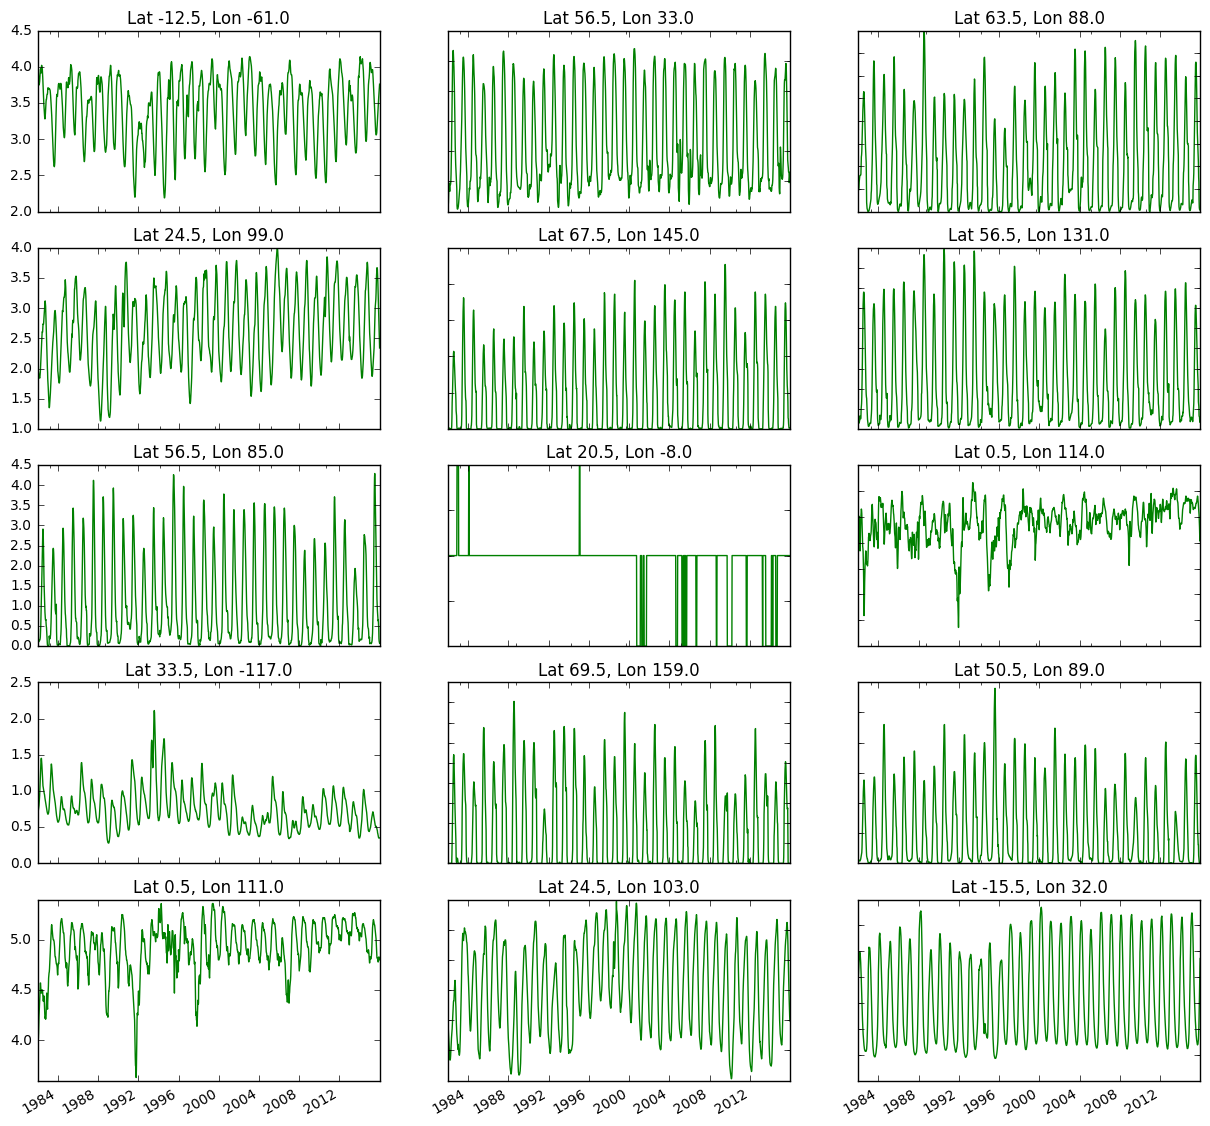

In [8]:
show_timeseries(LAI, ts=timestamps)

The LAI time series are certainly not stationary all around the globe. Let's remove the trend using [cdo](https://code.zmaw.de/projects/cdo/embedded/index.html#x1-5310002.10.2):

`cdo trend infile afile bfile
cdo subtrend infile afile bfile outfile`

First, let's have a look at some detrended timeseries: **THERE ARE NEGATIVE LAI VALUES**

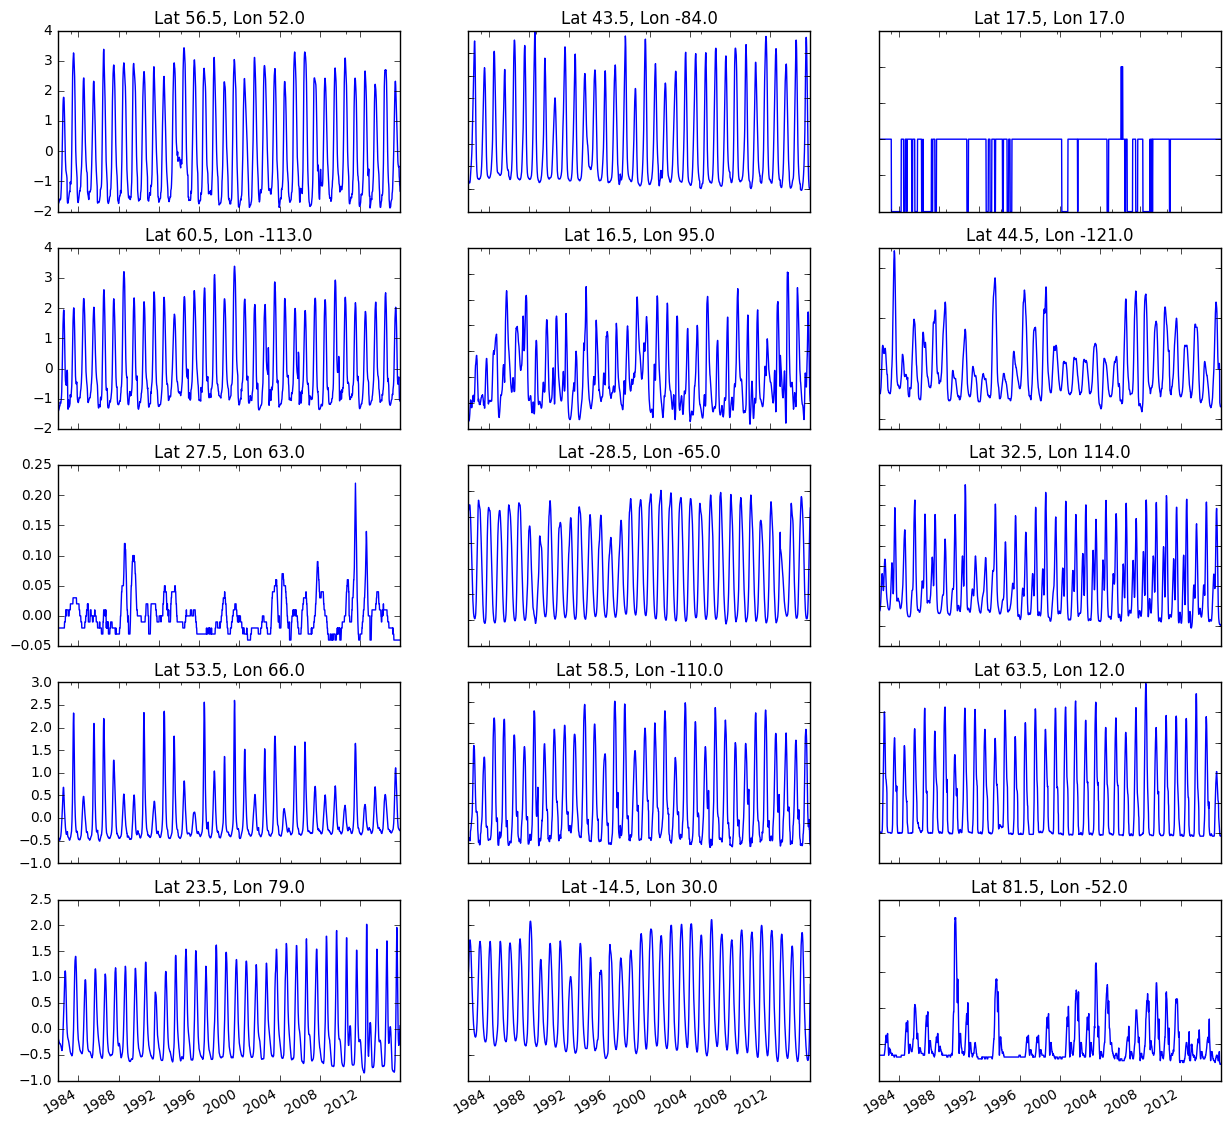

In [10]:
LAI_detrend_netcdf = Dataset(os.path.join(filepath, 'GLASSLAI2', 'GLASSLAI_DETREND.nc'),
                     'r', format='NETCDF3')
LAI_detrend_netcdf.set_auto_maskandscale(False)

LAI_detrend = LAI_detrend_netcdf['LAI'][::]*float(LAI_netcdf.variables['LAI'].scale_factor)
LAI_detrend = LAI_detrend[:,::-1,:]
show_timeseries(LAI_detrend, color='blue', ts=timestamps)
timestamps = LAI_detrend_netcdf.variables['time'][:]

In order to extract the seasonal component, we need the multi-year average LAI on the temporal resolution of the dataset. Unfortunately, the native resolution is not a standard monthly or daily resolution but a 9-day resolution, so there is no standard `cdo` operator available to calculate the multi-year average. Maybe pandas can do the trick. Let's consider one timeseries:

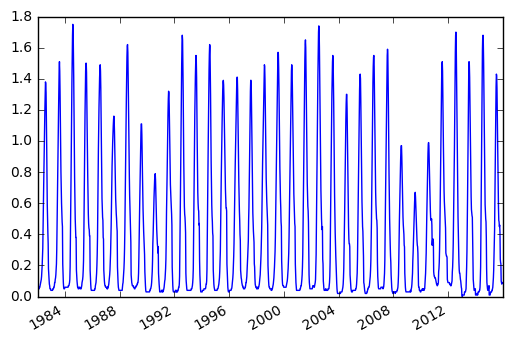

In [13]:
pixel = pd.Series(LAI[:, 20, 30], index=pd.to_datetime(timestamps+4383, unit='d'))
pixel.plot()

With pandas, we can group the data by day of the year and calculate the multi-year average:

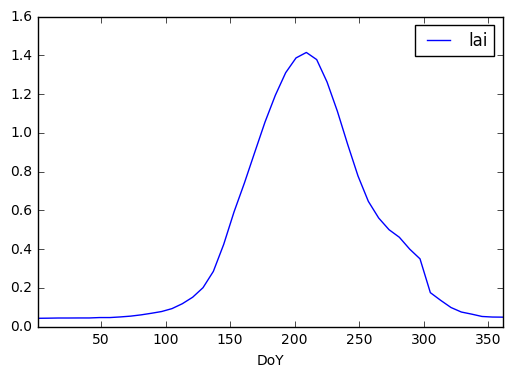

In [14]:
df = pd.DataFrame(pixel, columns=['lai'])
df['DoY'] = df.index.dayofyear
df.groupby(['DoY']).mean().plot()

In [15]:
pixel_resid = (df - df.groupby(['DoY']).transform('mean'))['lai']

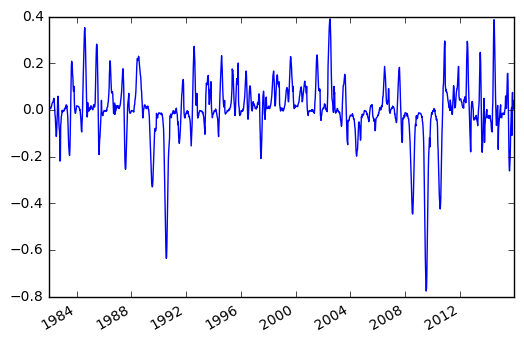

In [16]:
pixel_resid.plot()

Put this in a function:

In [17]:
def deseasonalize(ndarr):
    df = pd.DataFrame(ndarr, index=pd.to_datetime(timestamps+4383, unit='d'), columns=['lai'])
    df['DoY'] = df.index.dayofyear
    return ((df - df.groupby(['DoY']).transform('mean'))['lai']).values
    

And apply it over every timeseries in the LAI dataframe: **doesn't work, way too sloooow**

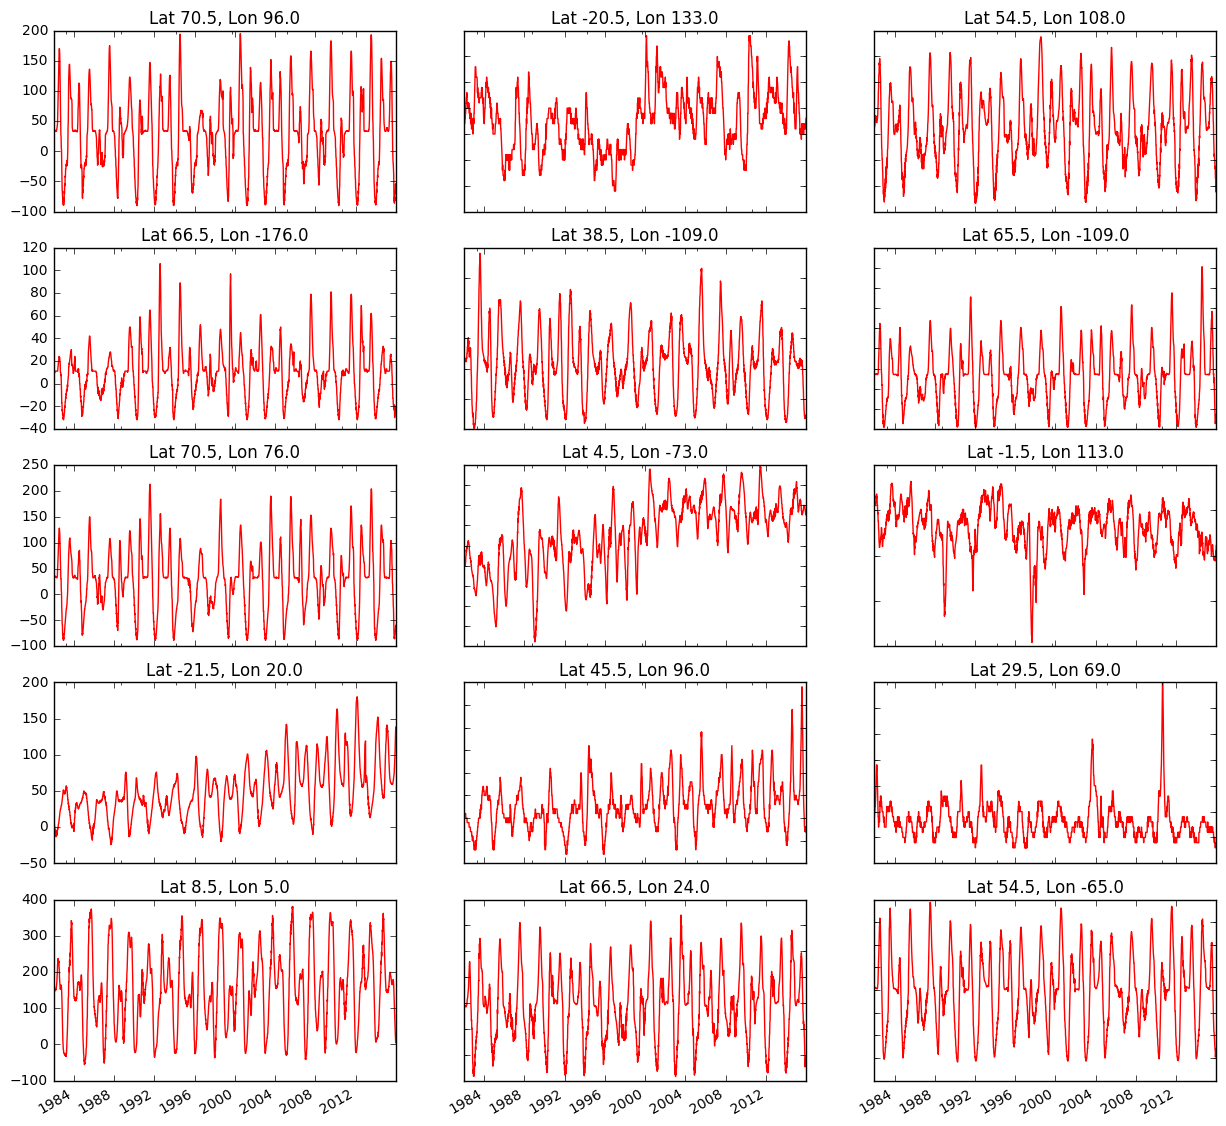

In [18]:
LAI_residuals_netcdf = Dataset(os.path.join(filepath, 'GLASSLAI2', 'GLASSLAI_residuals.nc'),
                     'r', format='NETCDF3')
LAI_residuals_netcdf.set_auto_maskandscale(False)

LAI_residuals = LAI_residuals_netcdf['LAI'][::]
LAI_residuals = LAI_residuals[:,::-1,:]
timestamps = LAI_residuals_netcdf.variables['time'][:]
show_timeseries(LAI_residuals, color='red', ts=timestamps)

Compute the multi-year daily mean and multi-year monthly mean:
    
`cdo ydaymean infile outfile`
`cdo ymonmean infile outfile`

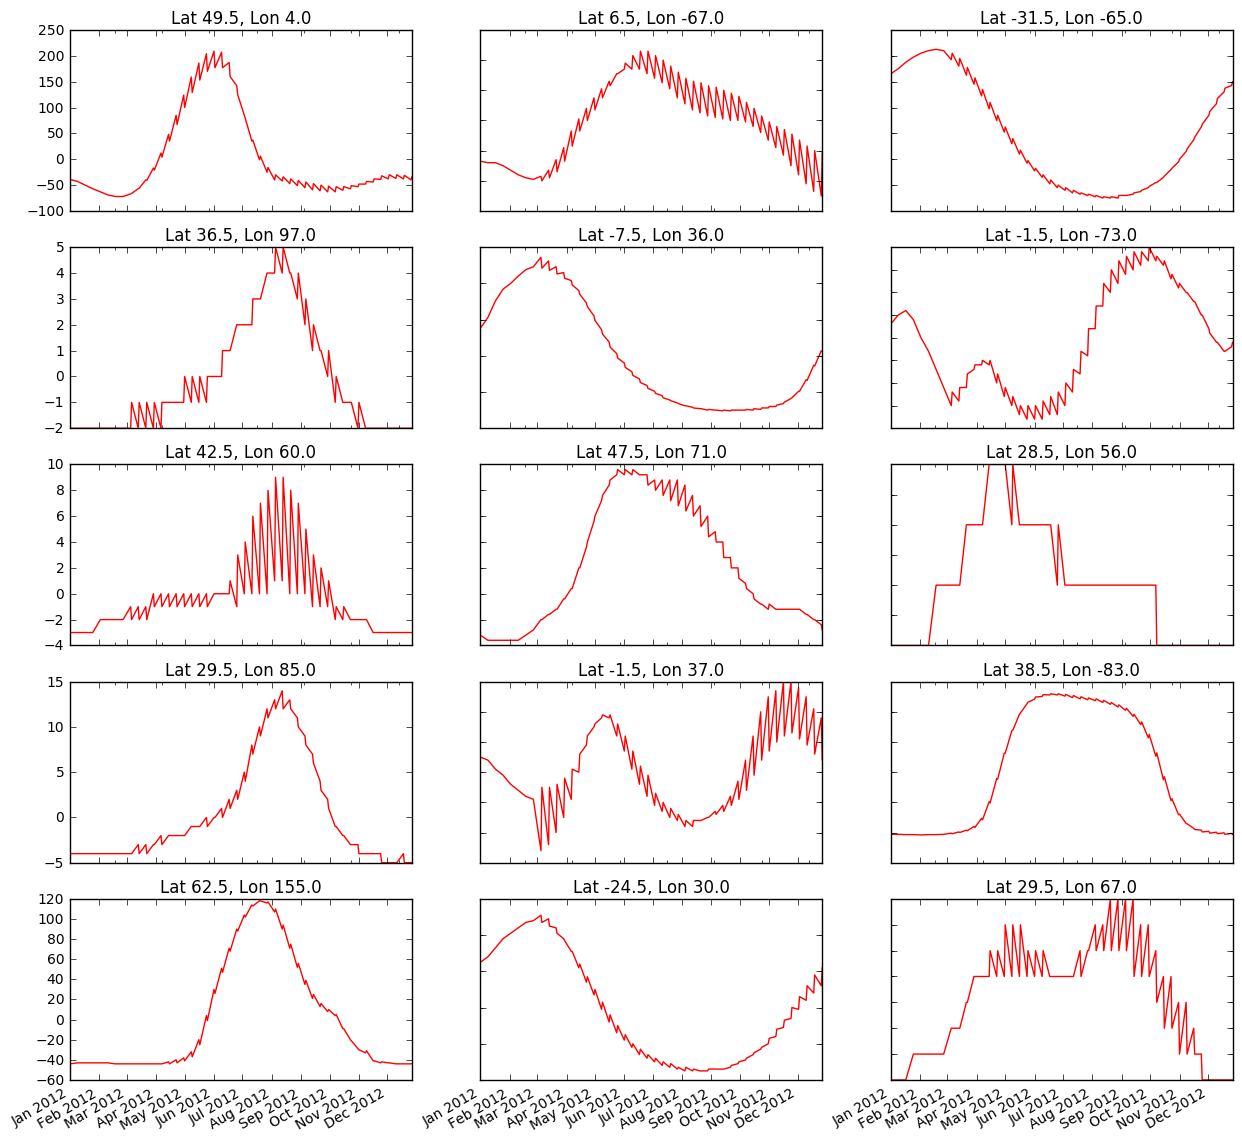

In [19]:
LAI_ydaymean_netcdf = Dataset(os.path.join(filepath, 'GLASSLAI2', 'GLASSLAI_ydaymean.nc'),
                     'r', format='NETCDF3')
LAI_ydaymean_netcdf.set_auto_maskandscale(False)

LAI_ydaymean = LAI_ydaymean_netcdf['LAI'][::]
LAI_ydaymean = LAI_ydaymean[:,::-1,:]
timestamps = LAI_ydaymean_netcdf.variables['time'][:]
show_timeseries(LAI_ydaymean, color='red', ts=timestamps)

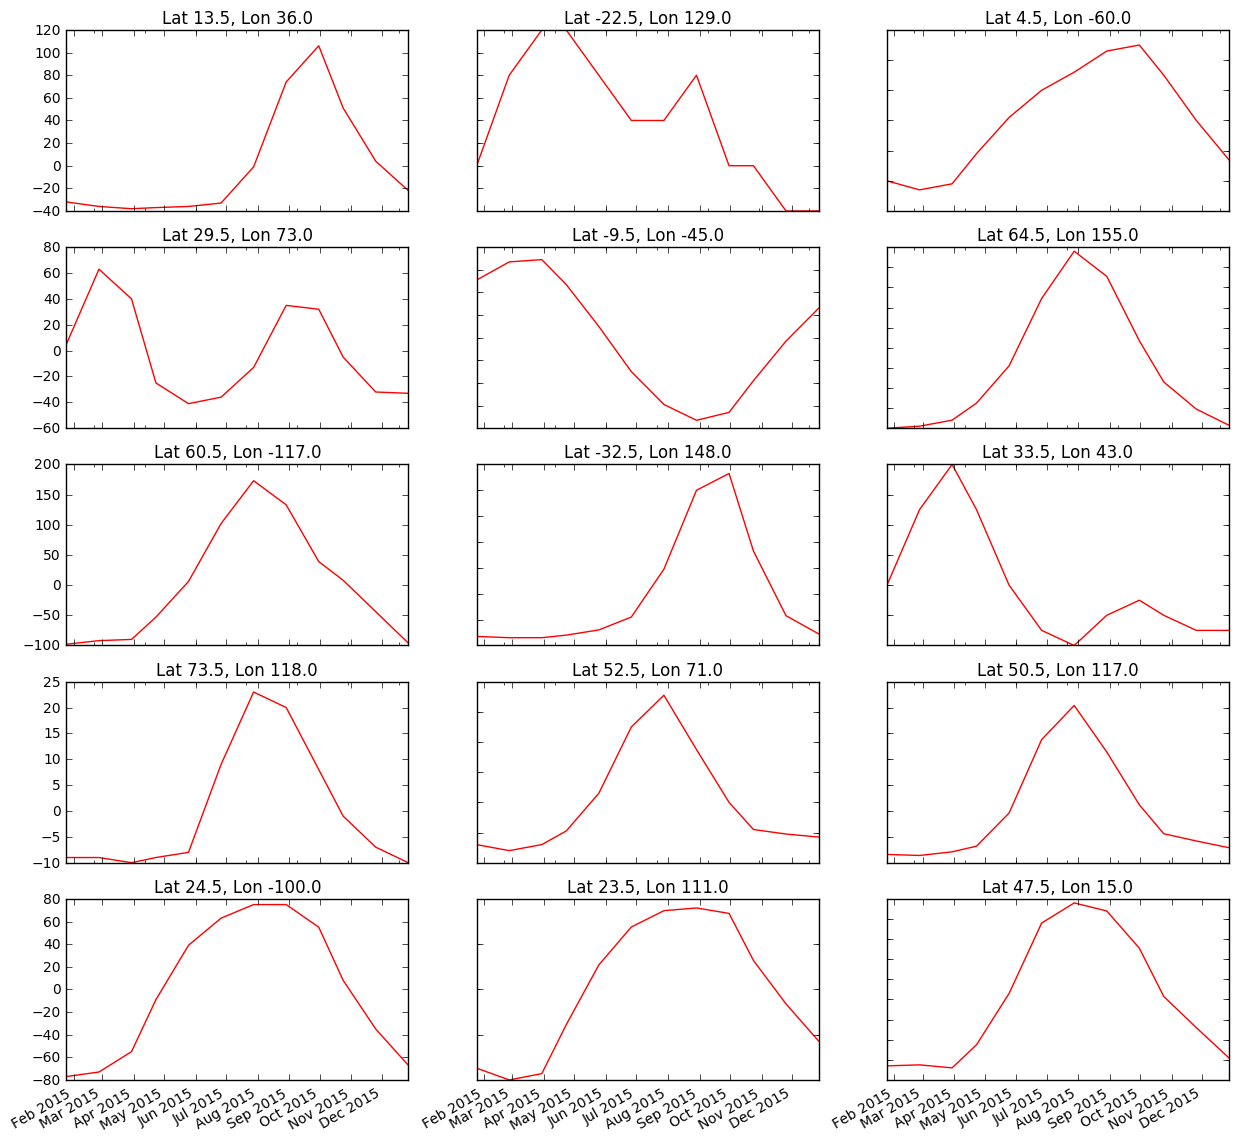

In [20]:
LAI_ymonmean_netcdf = Dataset(os.path.join(filepath, 'GLASSLAI2', 'GLASSLAI_ymonmean.nc'),
                     'r', format='NETCDF3')
LAI_ymonmean_netcdf.set_auto_maskandscale(False)

LAI_ymonmean = LAI_ymonmean_netcdf['LAI'][::]
LAI_ymonmean = LAI_ymonmean[:,::-1,:]
timestamps = LAI_ymonmean_netcdf.variables['time'][:]
show_timeseries(LAI_ymonmean, color='red', ts=timestamps)

In [71]:
len(timestamps)

12

In [41]:
len(timestamps)

84

In [49]:
timestamps = LAI_netcdf.variables['time'][:]
test = pd.to_datetime(timestamps+4383, unit='d')

In [50]:
test

DatetimeIndex(['1982-01-01', '1982-01-09', '1982-01-17', '1982-01-25',
               '1982-02-02', '1982-02-10', '1982-02-18', '1982-02-26',
               '1982-03-06', '1982-03-14',
               ...
               '2015-10-16', '2015-10-24', '2015-11-01', '2015-11-09',
               '2015-11-17', '2015-11-25', '2015-12-03', '2015-12-11',
               '2015-12-19', '2015-12-27'],
              dtype='datetime64[ns]', length=1564, freq=None)

In [63]:
len(np.unique(test.year))

34

TypeError: 'numpy.ndarray' object is not callable